In [1]:
import ee
ee.Initialize()

import geepy
import math
import sys
import geemap

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
config = geepy.params.configParams('input_parameters.json')
amostras = ee.FeatureCollection(config.params['samples']['crop_samples'])
region = ee.FeatureCollection(config.params['studyArea']) 

bands = config.params['bandParams']

l8 = ee.ImageCollection(config.params['imgCollection']['lc8']['sr']).select(
    config.params["imgCollection"]["lc8"]["bands"],
    config.params["imgCollection"]["lc8"]["bandNames"])

region = ee.FeatureCollection(config.params['studyArea']) 

tiles = ee.FeatureCollection(config.params['lsTiles'])

In [3]:
tile = [geepy.feature.getTiles(tiles, tile, 'TILE') for tile in config.params['grid']['tiles2process']]

In [4]:
samples = ee.FeatureCollection(config.params['samples']['crop_samples'])

In [5]:
samples_soybean = ee.FeatureCollection(config.params['samples']['crop_samples']).filter("NM_CULTURA == 'Soja'")
samples_wheat = ee.FeatureCollection(config.params['samples']['crop_samples']).filter("NM_CULTURA == 'Trigo'")
samples_maize = ee.FeatureCollection(config.params['samples']['crop_samples']).filter("NM_CULTURA == 'Milho 2ª safra'")
samples_others = ee.FeatureCollection(config.params['samples']['crop_samples']).filter("NM_CULTURA == 'outros'")

In [6]:
srtm = ee.Image(config.params['srtm'])
slope = ee.Terrain.slope(srtm)
aspect = ee.Terrain.aspect(srtm).divide(180).multiply(math.pi).sin()
hillshade = ee.Terrain.hillshade(srtm)

In [7]:
landsat = {}

for year in config.params['years2process']:  
    start_d = year + config.params['plantingDate']['soybean']['planting']['start']
    end_d = year + config.params['plantingDate']['soybean']['planting']['end']

    #print("Start-End dry season %s %s" %(start_d, end_d))

    filtered = l8.filterMetadata('CLOUD_COVER', 'less_than', config.params['cloudCoverThreshold']).filterDate(start_d, end_d).map(geepy.image.maskLandsatSR)
    satellite = 'l8'
        
    fEdgeRemoved = filtered.map(geepy.image.edgeRemoval).median()
    
    fEdgeRemovedMin = filtered.map(geepy.image.edgeRemoval).min()
    fEdgeRemovedMax = filtered.map(geepy.image.edgeRemoval).max()

    fEdgeRemoved = geepy.image.img2Band(fEdgeRemoved, srtm, 'srtm')
    fEdgeRemoved = geepy.image.img2Band(fEdgeRemoved, slope, 'slope')
    fEdgeRemoved = geepy.image.img2Band(fEdgeRemoved, aspect, 'aspect')
    fEdgeRemoved = geepy.image.img2Band(fEdgeRemoved, hillshade, 'hillshade')

    fEdgeRemoved = geepy.image.calcPSRI(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcNDVI(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcNDBI(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcEVI(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcSAVI(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcNDWI_L(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcNDWI_WB(fEdgeRemoved)
    fEdgeRemoved = geepy.image.calcRatio(fEdgeRemoved)

    fEdgeRemoved = geepy.image.tassCapTransformation(fEdgeRemoved, satellite)
        
    landsat[year] = fEdgeRemoved.clip(region)
        
    sys.stdout.write("\rProcessing Landsat data: %s" % year)
    sys.stdout.flush()

Processing Landsat data: 2020

In [16]:
Map = geemap.Map(center=(-24.7269, -51.6589), zoom=7)
Map.addLayer(landsat['2020'], {'min': 0.15,'max': 0.4,'bands': 'swir1,nir,red'}, 'RGB')
Map.addLayer(region, {
                  'color': '00000000',
                  'width': 2,
                  'fillColor': '00000000',
                  'lineType': 'solid',
                  'fillColorOpacity': 1
}, 'Limire Paraná')
Map.addLayer(samples_soybean, {
                'color': '77a605', 
                'colorOpacity': 0,
                'pointSize': 2,
                'pointShape': 'circle',
                'width': 1,
                'lineType': 'solid', 
                'fillColorOpacity': 0.66
}, 'Soja')
Map.addLayer(samples_wheat, {
                'color': 'b8af4f', 
                'colorOpacity': 0,
                'pointSize': 2,
                'pointShape': 'circle',
                'width': 1,
                'lineType': 'solid', 
                'fillColorOpacity': 0.66
}, 'Trigo')
Map.addLayer(samples_maize, {
                'color': 'ffff8d', 
                'colorOpacity': 0,
                'pointSize': 2,
                'pointShape': 'circle',
                'width': 1,
                'lineType': 'solid', 
                'fillColorOpacity': 0.66
}, 'Milho 2ª safra')
Map.addLayer(samples_others, {
                'color': '222222', 
                'colorOpacity': 0,
                'pointSize': 2,
                'pointShape': 'circle',
                'width': 1,
                'lineType': 'solid', 
                'fillColorOpacity': 0.66
}, 'outros')

legend = """

Value	Color	Description
1	77a605	Soja
2	b8af4f	Trigo
3	ffff8d	Milho 2ª safra

"""
legend_dict = geemap.legend_from_ee(legend)
Map.add_legend(legend_title="Classes", legend_dict=legend_dict)
Map

Map(center=[-24.7269, -51.6589], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…

In [9]:
samples = samples.randomColumn('randCol', 0)

In [10]:
training = samples.filter(ee.Filter.gt('randCol', 0.2))
validation = samples.filter(ee.Filter.lt('randCol', 0.2))

In [11]:
trained = geepy.image.trainingSamples(landsat['2020'], training)

In [12]:
#task = geepy.feature.send2drive(trained, 'samples_2020', 'classification_parana_500t', 'trained', 'CSV')
#task.start()

In [13]:
# Randon Forest
classification = {year: geepy.image.randomForest(landsat[year], trained, bands, ntrees=500) for (year) in config.params['years2process']}

In [14]:
#tasks = {year: geepy.image.send2drive(classification[year][0], config.params['extent'], 'classification_' + year, 'classification_parana_500t', 30) for year in config.params['years2process']}

#for i in tasks.keys():
#    [tasks[i].start()]

In [15]:
confusionMatrix = classification['2020'][1].getInfo()

In [16]:
confusionMatrix

[[0, 0, 0, 0, 0],
 [0, 2480, 1, 6, 16],
 [0, 35, 499, 0, 9],
 [0, 186, 3, 1043, 0],
 [0, 24, 9, 3, 6907]]

In [17]:
confusionMatrix = np.delete(confusionMatrix, 0, 0)
confusionMatrix = np.delete(confusionMatrix, 0, 1)

In [18]:
trainingConfusionMatrix = pd.DataFrame(np.asarray(confusionMatrix), index = ['Soja','Trigo','Milho 2ª safra', 'outros'], columns = ['Soja','Trigo','Milho 2ª safra', 'outros'])

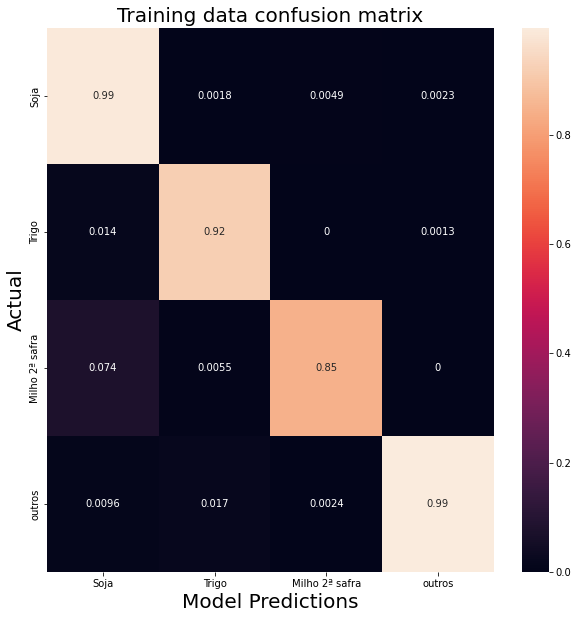

In [19]:
fig, ax = plt.subplots(1, figsize = (10,10))
sns.heatmap(trainingConfusionMatrix/trainingConfusionMatrix.sum(axis = 1), annot = True)
ax.set_xlabel('Model Predictions', fontsize = 20)
ax.set_ylabel('Actual', fontsize = 20)
plt.title("Training data confusion matrix", fontsize = 20);

In [20]:
trainingConfusionMatrix

,Soja,Trigo,Milho 2ª safra,outros
Soja,2480,1,6,16
Trigo,35,499,0,9
Milho 2ª safra,186,3,1043,0
outros,24,9,3,6907


In [18]:
Map = geemap.Map(center=(-24.7269, -51.6589), zoom=7)
Map.addLayer(landsat['2020'], {'min': 0.15,'max': 0.4,'bands': 'swir1,nir,red'}, 'RGB')
Map.addLayer(classification['2020'][0], {'min': 1,'max': 4,'palette': '#77a605, #b8af4f, #ffff8d, #888888'}, 'Classificação')

Map.addLayer(region, {
                  'color': '00000000',
                  'width': 2,
                  'fillColor': '00000000',
                  'lineType': 'solid',
                  'fillColorOpacity': 1
}, 'Limire Paraná')


legend = """

Value	Color	Description
1	77a605	Soja
2	b8af4f	Trigo
3	ffff8d	Milho 2ª safra

"""
legend_dict = geemap.legend_from_ee(legend)
Map.add_legend(legend_title="Classes", legend_dict=legend_dict)
Map

Map(center=[-24.7269, -51.6589], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(c…